# Librería Darts

Este notebook se basa en contenido de:
- https://unit8co.github.io/darts/quickstart/00-quickstart.html
- https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html

Vamos a utilizar la librería **darts**, una herramienta de código abierto diseñada para la predicción de series temporales y la detección de anomalías. Proporciona una interfaz fácil de usar y admite una amplia gama de modelos de pronóstico. Entre sus características clave están:
- **Diversos Modelos de Predicción**: Darts incluye varios modelos, desde métodos estadísticos tradicionales como ARIMA y ETS hasta enfoques modernos de aprendizaje automático como XGBoost, CatBoost y modelos de aprendizaje profundo como N-BEATS. Esta variedad permite a los usuarios experimentar con diferentes algoritmos para encontrar el que mejor se adapte a sus datos.
- **API Unificada**: La biblioteca utiliza una interfaz consistente con los métodos fit() y predict() en todos los modelos, similar a *scikit-learn*, lo que simplifica el proceso de entrenamiento y predicción del modelo.
- **Soporte para Series Temporales Multivariadas**: Darts puede manejar tanto series temporales univariadas como multivariadas, lo que permite a los usuarios analizar conjuntos de datos complejos con múltiples variables interactivas.
- **Capacidades de Detección de Anomalías**: Además de la predicción, Darts ofrece herramientas para detectar anomalías en los datos de series temporales, lo cual es esencial para identificar valores atípicos que pueden afectar el análisis.
- **Backtesting y Comparación de Modelos**: La biblioteca incluye funcionalidades para realizar backtesting en los modelos, permitiendo a los usuarios simular pronósticos históricos y comparar la efectividad de diferentes modelos.
- **Predicción Probabilística**: Algunos modelos en Darts admiten la predicción probabilística, lo que puede proporcionar intervalos de confianza para las predicciones, mejorando la fiabilidad de los pronósticos.
- **Integración con Datos Externos**: Darts permite la incorporación de covariables externas (tanto pasadas como futuras) en los modelos de predicción, mejorando la precisión al considerar información adicional relevante.

Para instalarla:

- Anaconda: `conda install -c conda-forge -c pytorch u8darts-all`
- Pip: `pip install darts`

# Preparación de datos de series de tiempo

La clase de trabajo principal en **Darts** es **`TimeSeries`**, que representa una serie temporal univariada o multivariada.
Todos los modelos en **Darts** consumen y producen `TimeSeries`.
`TimeSeries` también incluyen un índice de tiempo o de secuencia, que puede ser de tipo `pandas.DatetimeIndex` (fechas y horas) o de tipo `pandas.RangeIndex` (en caso de datos secuenciales no necesariamente asociados a marcas de tiempo específicas).
Además, `TimeSeries` puede por extensión representar series probabilísticas, por ejemplo, para obtener intervalos de confianza. 

Una instancia de `TimeSeries` se puede obtener de varias maneras, partiendo, entre otras, de:
- un `DataFrame` de Pandas, usando `TimeSeries.from_dataframe()`.
- una `Series` de Pandas, usando `TimeSeries.from_series()`.
- un índice de tiempo y de un conjunto de valores correspondientes, usando `TimeSeries.from_times_and_values()`.
- un `nparray` de NumPy, usando `TimeSeries.from_values()`.
- un archivo CSV, usando `TimeSeries.from_xarray()`

También hay un conjunto de datasets disponibles en la misma librería **Darts**. Vamos por ejemplo a cargar el conocido dataset de "Air Passengers" para ilustrar operaciones con los objetos de tipo `TimeSeries`.

In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.utils.missing_values import fill_missing_values

In [2]:
series = AirPassengersDataset().load()
print(type(series))
print(len(series))
print(series.columns)

<class 'darts.timeseries.TimeSeries'>
144
Index(['#Passengers'], dtype='object', name='component')


Las instancias de `TimeSeries`, con su método `plot()`, ya vienen con la funcionalidad de poder crear figuras con sus valores.

<Axes: xlabel='Month'>

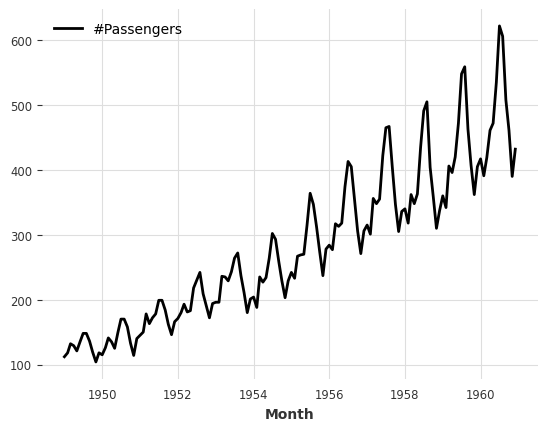

In [3]:
series.plot()

Por defecto, al plotear una instancia de `TimeSeries`, se utiliza el nombre de sus columnas de datos. Se puede también indicar como argumento un nombre diferente.
Más adelante mostramos como cambiar el nombre de la serie en la instancia misma.

<Axes: xlabel='Month'>

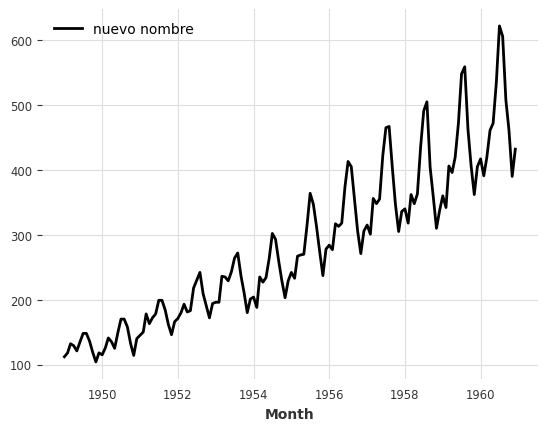

In [4]:
series.plot(label="nuevo nombre")

Podemos acceder a los elementos de las series a partir de una indexación de posición o partir de un timestamp que referencia el índice temporal interno manejado.

In [5]:
series[108]

<TimeSeries (DataArray) (Month: 1, component: 1, sample: 1)> Size: 8B
array([[[340.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 8B 1958-01-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
series[pd.Timestamp('1958-01-01')]

<TimeSeries (DataArray) (Month: 1, component: 1, sample: 1)> Size: 8B
array([[[340.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 8B 1958-01-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

En el caso en el una serie de tiempo tenga **valores faltantes**, se puede utilizar el método `fill_missing_values()` para imputarlos.

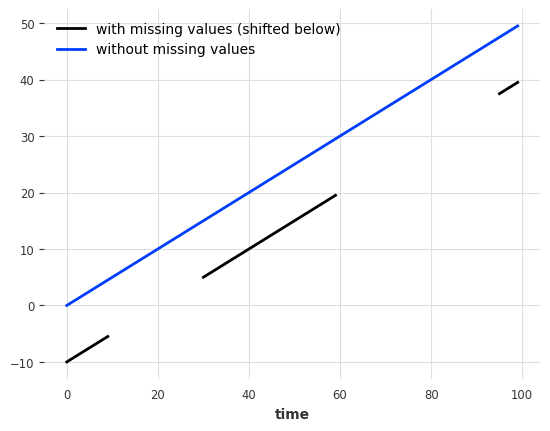

In [7]:
# Creamos una serie de tiempo con huecos
values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values");

## Particionamiento de series

La manipulación de la clase `TimeSeries` a partir de sus métodos es bastante intuitiva. La clase proporciona métodos de **particionamiento**: `split_before()`, `split_after()`, `drop_before()`, `drop_after()`, que reciben un índice de corte (numérico o valor), o un porcentaje del dataset (entre 0 y 1).

Por ejemplo, vamos a crear a dividir una serie en dos, con la primera conservando el 75% de los datos y la segunda el resto.

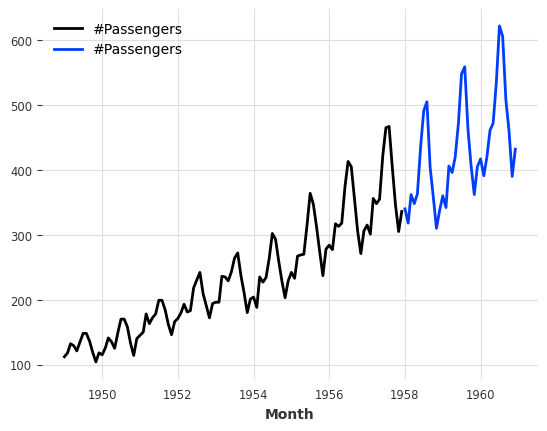

In [8]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot();

La misma tarea se puede realizar utilizando un valor del índice temporal:

<Axes: xlabel='Month'>

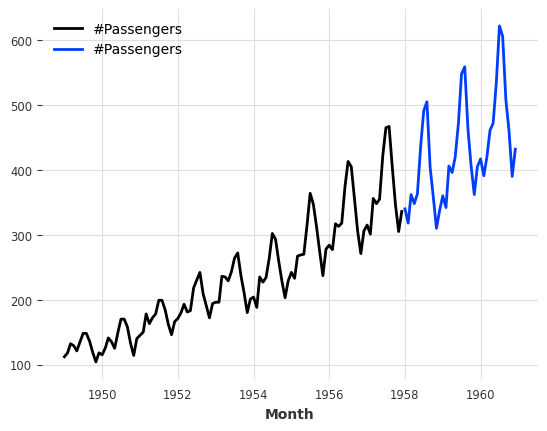

In [9]:
series1, series2 = series.split_before(pd.Timestamp('1958-01-01'))
series1.plot()
series2.plot()

La misma tarea se puede hacer con una manipulación similar a la utilizada en numpy:

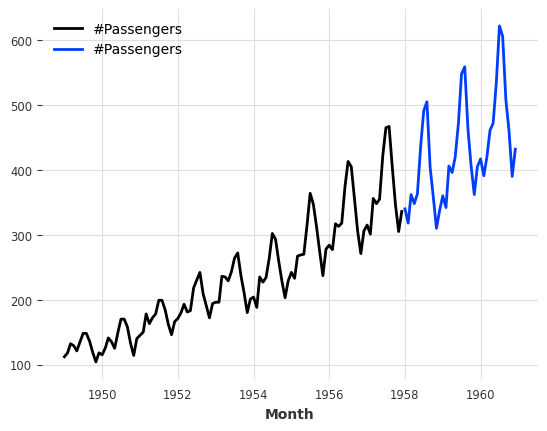

In [10]:
series1, series2 = series[:108], series[108:]
series1.plot()
series2.plot();

## Modificación de los valores

Se pueden **combinar** series temporales **aritméticamente**, validando previamente que haya una correspondencia en el tamaño e índice de las mismas.
En el siguiente ejemplo creamos una serie de tiempo con valores de ruido aleatorio, y los combinamos artiméticamente con los datos de la serie de tiempo de base.
En este ejemplo tenemos tres objetos diferentes independientes, cada uno con su serie de tiempo.

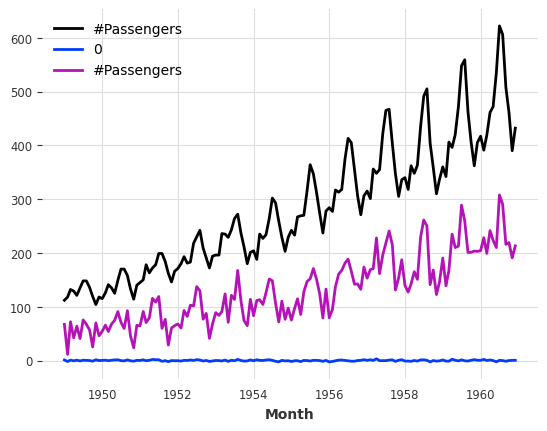

In [11]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
series.plot();
series_noise.plot();
(series / 2 + 20 * series_noise - 10).plot();

Podemos también modificar el nombre de las series de tiempo. Internamente `TimeSeries` guarda los valores en columnas.
Podemos cambiar sus nombres con el método `with_columns_renamed()`.

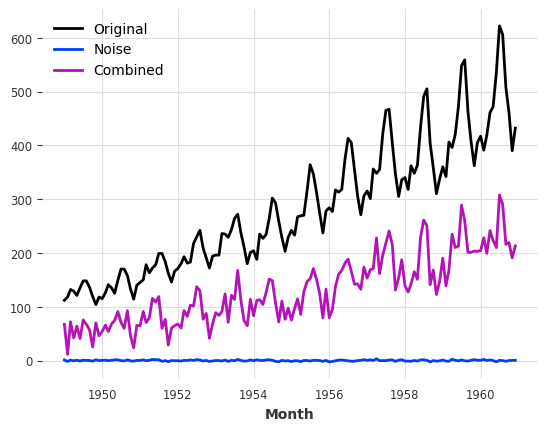

In [12]:
series_original = series.with_columns_renamed('#Passengers', 'Original')
series_noise_renamed = series_noise.with_columns_renamed('0', 'Noise')
series_new = (series_original / 2 + 20 * series_noise_renamed - 10)
series_new = series_new.with_columns_renamed('Original', 'Combined')

series_original.plot();
series_noise_renamed.plot();
series_new.plot();

Se puede aplicar una función a los valores de una serie utilizando el método `map()`:

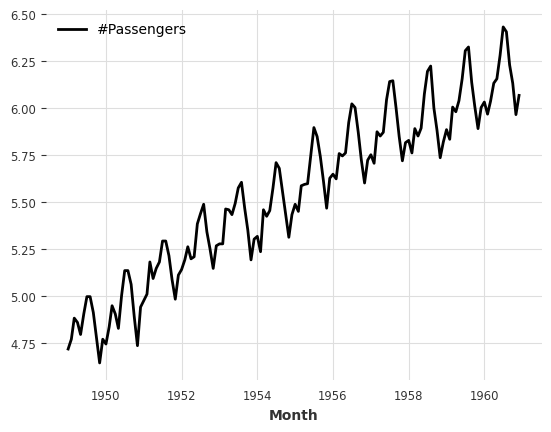

In [13]:
series.map(np.log).plot();

También se puede aplicar funcione inline (**lambda**) teniendo en cuenta no solo su valor sino su índice temporal:

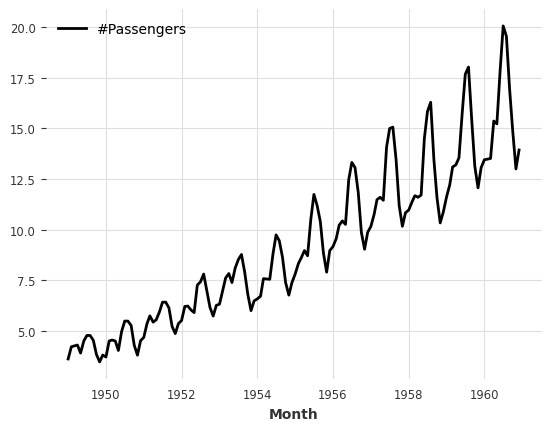

In [14]:
series.map(lambda ts, x: x / ts.days_in_month).plot();

## Series Multivariadas

Podemos en una misma instancia de `TimeSeries` tener varias series de tiempo. Internamente se manejan como columnas almacenadas en una misma estructura.
Esto va a ser el punto de partida eventual de modelos **multivariados**.
Se puede crear esta serie multivariada a partir del método `stack()`.

In [15]:
series_multiples = (series_original / 50).stack(series_noise_renamed)
series_multiples.columns

Index(['Original', 'Noise'], dtype='object', name='component')

<Axes: xlabel='Month'>

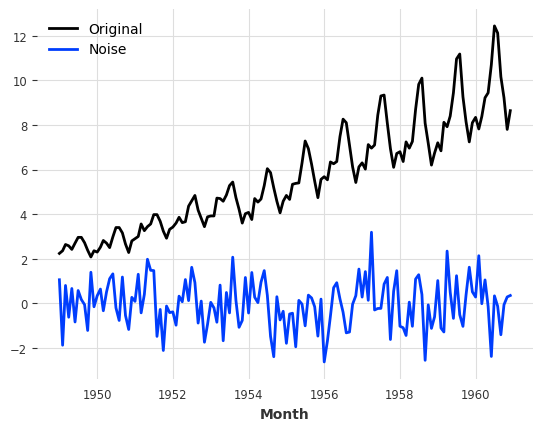

In [16]:
series_multiples.plot()

Podemos agregar también una serie de tiempo asociada a componentes temporales.
Por ejemplo, creamos un nuevo componente con el mes de cada valor con el método `add_datetime_attribute()` o un nuevo componente con los días festivos con el método `add_holidays()`.

In [17]:
series_multiples = series_multiples.add_datetime_attribute("month").add_holidays("CO")+1
series_multiples.columns

Index(['Original', 'Noise', 'month', 'holidays'], dtype='object', name='component')

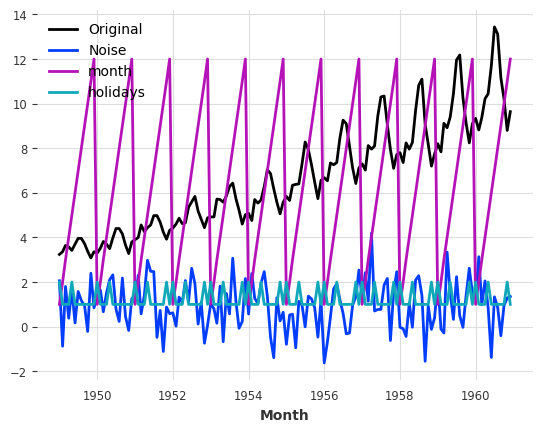

In [18]:
series_multiples.plot();

In [19]:
series_multiples.columns

Index(['Original', 'Noise', 'month', 'holidays'], dtype='object', name='component')

Otro tipo de operaciones comunes con las series de tiempo tambien están disponibles, por ejemplo la diferenciación con el método `diff()`.

<Axes: xlabel='Month'>

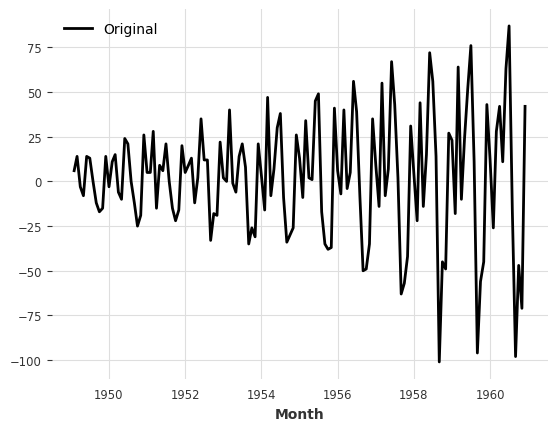

In [20]:
series_original.diff().plot()

# Entrenamiento, predicción y evaluación de modelos en Darts

## Modelos Baseline

Los modelos **baseline** en forecasting son métodos simples pero efectivos que sirven como referencia para comparar el rendimiento de modelos más complejos. 
Entre los muchos modelos disponibles en **Darts** se encuentran los modelos **baseline** o **naïve** (ingenuos) que sirven como punto de partida en tareas de predicción de series temporales:
- `NaiveSeasonal`: Repite valores pasados basados en una periodicidad (estacionalidad) definida por el usuario a través de un argumento `K`. Útil para datos con una fuerte estacionalidad. Si se quiere un modelo que repita el último valor, se crea una instancia con un valor `K=1`.
- `NaiveDrift`: Asume una tendencia lineal entre el primer y el último punto del conjunto de entrenamiento y extrapola esa tendencia hacia adelante.
- `NaiveMean`: Predice el último valor observado en los datos de entrenamiento para todos los pasos futuros.

A continuación ilustramos el **flujo de trabajo típico con Darts**, desde la carga de los datos, pasando por la instanciación de los modelos, su entrenamiento (con el método `fit()`, que recibe la serie de tiempo de entrenamiento), su uso en la predicción (con el método `predict()`, que recibe el número de pasos futuros a predecir), la evaluación de los valores predichos (utilizando métricas de error), y finalmente la visualización de los resultados (con un plot).
Es un enfoque muy similar al seguido por **Scikit-learn**, excepto que para series de tiempo.


Error MAPE seasonal: 14.03790054823889
Error MAPE drift: 27.625750480799717
Error MAPE mean: 43.85248268160258


<Axes: xlabel='Month'>

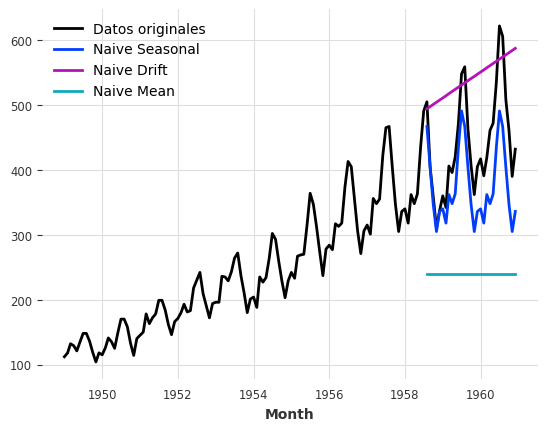

In [21]:
# 1. Carga y preparación de datos:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
series = AirPassengersDataset().load()

# 2. División del conjunto de datos:
train, test = series.split_after(0.8)  # 80% entrenamiento, 20% prueba

# 3. Entrenamiento del modelo:
from darts.models import NaiveSeasonal, NaiveDrift, NaiveMean
model_naive_seasonal = NaiveSeasonal(K=12)
model_naive_seasonal.fit(train)
model_naive_drift = NaiveDrift()
model_naive_drift.fit(train)
model_naive_mean = NaiveMean()
model_naive_mean.fit(train)

# 4. Predicción:
forecast_naive_seasonal = model_naive_seasonal.predict(len(test))
forecast_naive_drift = model_naive_drift.predict(len(test))
forecast_naive_mean = model_naive_mean.predict(len(test))

# 5. Evaluación del modelo:
from darts.metrics import mape
error_naive_seasonal = mape(test, forecast_naive_seasonal)
print(f"Error MAPE seasonal: {error_naive_seasonal}")
error_naive_drift = mape(test, forecast_naive_drift)
print(f"Error MAPE drift: {error_naive_drift}")
error_naive_mean = mape(test, forecast_naive_mean)
print(f"Error MAPE mean: {error_naive_mean}")

# 6. Visualización resultados:
series.plot(label="Datos originales")
forecast_naive_seasonal.plot(label="Naive Seasonal")
forecast_naive_drift.plot(label="Naive Drift")
forecast_naive_mean.plot(label="Naive Mean")

## Modelos más complejos

Podemos fácilmente probar con varios modelos más complejos. Vemos en el siguiente código que se puede acceder a modelos implementados en frameworks de Deep Learning que hacen uso de la GPU disponible, sin necesidad de realizar ninguna tarea de bajo nivel.

In [22]:
from darts.models import AutoARIMA, ExponentialSmoothing, Prophet, TCNModel, RNNModel

def probar_modelo(modelo, nombre):
    modelo.fit(train)
    forecast = modelo.predict(len(test))
    error = mape(test, forecast)
    print(f"Error MAPE {nombre}: {error}")
    return modelo

modelo_ExpSmt = probar_modelo(ExponentialSmoothing(), "ExponentialSmoothing")
modelo_Arima = probar_modelo(AutoARIMA(), "AutoARIMA")
modelo_Prophet = probar_modelo(Prophet(), "Prophet")
modelo_TCN1 = probar_modelo(
    TCNModel(
        input_chunk_length=12,  # Ventana de entrada (tamaño del historial)
        output_chunk_length=1,  # Ventana de predicción)
    ), "TCN - 1")
modelo_TCN6 = probar_modelo(
    TCNModel(
        input_chunk_length=12,  # Ventana de entrada (tamaño del historial)
        output_chunk_length=6,  # Ventana de predicción
    ), "TCN - 6")
modelo_LSTM = probar_modelo(RNNModel(model="LSTM", input_chunk_length=12), "LSTM")
modelo_GRU = probar_modelo(RNNModel(model="GRU", input_chunk_length=12), "GRU")

Error MAPE ExponentialSmoothing: 6.708082566847175


09:00:29 - cmdstanpy - INFO - Chain [1] start processing


Error MAPE AutoARIMA: 13.4078092415877


09:00:30 - cmdstanpy - INFO - Chain [1] done processing
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Error MAPE Prophet: 7.719622570691255



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 92     | train
-------------------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 92     | train
-------------------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Error MAPE TCN - 1: 51.70755349587509


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Error MAPE TCN - 6: 14.82515996606621


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | GRU              | 2.1 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Error MAPE LSTM: 99.00140388971245


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

Error MAPE GRU: 98.3826673664234


## BackTesting

Ya tenemos una idea de cuál es el mejor modelo según el conjunto de validación.
Ahora queremos saber cuál habría sido su rendimiento si hubiéramos estado usando este modelo históricamente en los periodos anteriores.
El **backtesting** simula las predicciones que se habrían obtenido históricamente con un modelo dado. 
Para producir estos resultados, el modelo se vuelve a entrenar (por defecto) cada vez que avanza el tiempo de predicción simulado.

Vamos a llamar al método `historical_forecasts()` del mejor modelo para simular pronósticos realizados para 3 meses en el futuro (en comparación con el tiempo de predicción). La configuración del backtest con este método recibe los siguiente parámetros:
- **series** (`TimeSeries`): La serie temporal sobre la cual se van a realizar las predicciones históricas.
- **past_covariates** (`Optional[TimeSeries]`): Series covariantes pasadas que pueden ser utilizadas por el modelo para realizar las predicciones.
- **start** (`Union[pd.Timestamp, float, int, None]`): El punto de inicio desde el cual se comenzarán a realizar las predicciones históricas. Puede ser una marca de tiempo (pd.Timestamp), un índice (entero) o un porcentaje del tamaño de la serie (float entre 0 y 1). Por defecto es 0.5 (es decir, el 50% del tamaño de la serie).
- **forecast_horizon** (`int`): La cantidad de pasos hacia adelante que el modelo debe predecir en cada iteración.
- **stride** (`int`): Número de pasos entre dos predicciones consecutivas en la serie histórica.
- **retrain** (`bool`): Indica si el modelo debe ser reentrenado en cada iteración. Por defecto es `True`.
- **last_points_only** (`bool`): Indica si se quiere que se devuelva solo el último valor predicho de cada ventana de predicción en lugar de toda la ventana de predicción. Por defecto es False.

El método `historical_forecasts()` genera pronósticos históricos simulando predicciones en varios puntos a lo largo del historial de la(s) serie(s) proporcionada(s). Este proceso implica aplicar retrospectivamente el modelo a diferentes pasos de tiempo, como si los pronósticos se hubieran realizado en tiempo real en esos momentos específicos. Esto permite evaluar el rendimiento del modelo durante toda la duración de la serie, proporcionando información sobre su precisión predictiva y robustez a lo largo de diferentes períodos históricos. Si`retrain=True`, para cada punto de corte, se reentrenará el modelo con los datos previos.

Con `last_points_only=True`, este método devuelve una sola `TimeSeries` (o una secuencia de series temporales) compuesta por el último punto de cada pronóstico histórico. Si `last_points_only=False`, en su lugar devolverá una lista (o una secuencia de listas) de todas las `TimeSeries` de pronósticos históricos completas.

Vamos a realizar un pronóstico de solo el último valor predicho de cada uno de los pronósticos realizados durante 3 meses, empezando en enero de 1956.

In [23]:
antes, despues = series.split_before(pd.Timestamp('1956-01-01'))
print(len(antes))
print(len(despues))

84
60


Para el primer paso de tiempo, se entrenará entonces con los primeros 84 meses, y se predecirán los siguientes 3 meses.
Como vamos a dejar el valor de `stride=1` (valor por defecto), sobre los 60 meses siguientes podremos entonces predecir (60-3)+1=58 ventanas de tamaño 3.

In [24]:
# Definimos un diccionario con los hiperparámetros del backtesting
hfc_params = {
    "series": series,
    "retrain": True,
    "start": pd.Timestamp("1956-01-01"), # el backtest lo hacemos solo desde esta fecha
    "forecast_horizon": 3, # para cada paso de tiempo del pasado predecimos 3 pasos de tiempo
    "verbose": True,
}

Cuando especificamos last_points_only=True, obtenemos una única TimeSeries con los 58 valores del último paso de tiempo predicho de cada predicción de 3 pasos.

In [25]:
#Backtest en el que solo nos quedamos con el ultimo dato de cada predicción
historical_fcast_ExpSmt_ultimo = modelo_ExpSmt.historical_forecasts(
    last_points_only=True, 
    **hfc_params,
)

print(type(historical_fcast_ExpSmt_ultimo))
print(len(historical_fcast_ExpSmt_ultimo))
historical_fcast_ExpSmt_ultimo[0]

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

<class 'darts.timeseries.TimeSeries'>
58


<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)> Size: 8B
array([[[309.08402333]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 1956-03-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Podemos plotear esta series para compararla con los datos reales. Hay que tener en cuenta que estamos considerando como factor importante el reentrenamiento del modelo con los datos nuevos que se disponibilizan a medida que pasa el tiempo.

MAPE = 4.36%


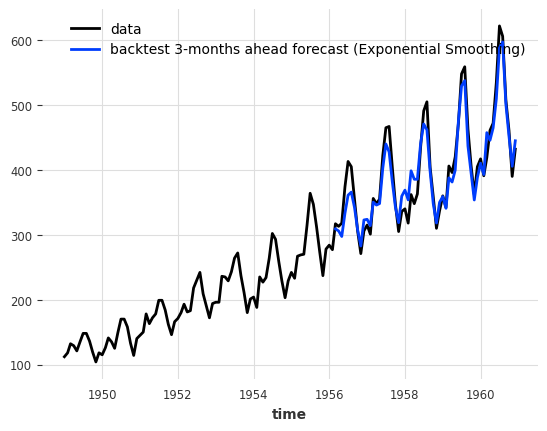

In [26]:
series.plot(label="data")
historical_fcast_ExpSmt_ultimo.plot(label="backtest 3-months ahead forecast (Exponential Smoothing)")
print(f"MAPE = {mape(series, historical_fcast_ExpSmt_ultimo):.2f}%")

Cuando ponemos que queremos todos los puntos, obtenemos una lista con 58 componentes de tipo `TimeSeries`, una por cada predicción, compuesta por los 3 valores de los 3 pasos de tiempo siguientes. Vamos a especificar un stride de 3 para simular lo que pasaría si no solo hacemos las predicciones para los siguientes 3 meses, sino que también las realizamos cada 3 meses. Este tipo de decisiones se podría tomar por ejemplo por cuestines de costos de cómputo, o por conocimiento de negocio que informe que los comportamientos no varían tanto de mes a mes.

In [27]:
#Backtest en el que solo nos quedamos con todos los pasos de tiempo futuros predichos
historical_fcast_ExpSmt_todos = modelo_ExpSmt.historical_forecasts(
    last_points_only=False, 
    stride=3,
    **hfc_params,
)

print(type(historical_fcast_ExpSmt_todos))
print(len(historical_fcast_ExpSmt_todos))
print(type(historical_fcast_ExpSmt_todos[0]))
historical_fcast_ExpSmt_todos[0]

historical forecasts:   0%|          | 0/20 [00:00<?, ?it/s]

<class 'list'>
20
<class 'darts.timeseries.TimeSeries'>


<TimeSeries (DataArray) (Month: 3, component: 1, sample: 1)> Size: 24B
array([[[280.93549307]],

       [[281.79129877]],

       [[309.08402333]]])
Coordinates:
  * Month      (Month) datetime64[ns] 24B 1956-01-01 1956-02-01 1956-03-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Encontramos que en los 60 datos de validación alcanzamos a posicionar 20 ventanas de 3 pasos de tiempo.

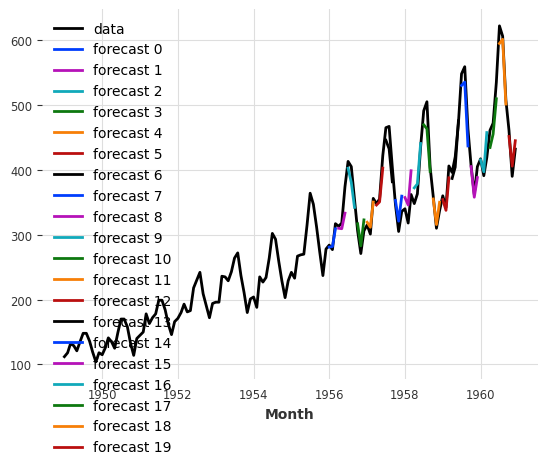

In [28]:
series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_ExpSmt_todos):
    hfc.plot(label=f"forecast {idx}")

Para evaluar el impacto en el error de predicción, concatenamos las 20 series predichas y las comparamos con la serie de datos real.

In [29]:
from darts import concatenate

historical_fcast_ExpSmt_todos_concat = concatenate(historical_fcast_ExpSmt_todos, axis=0)
print(f"MAPE = {mape(series, historical_fcast_ExpSmt_todos_concat):.2f}%")

MAPE = 3.68%


En este caso encontramos que nos va mejor haciendo la predicción cada trimestre. Esto se puede explicar por una volatilidad mensual demasiado importante que puede introducir un sesgo importante en las predicciones.

Finalmente, podemos analizar los resultados de cada set de predicciones con el método `backtest()`. Nos interesa que la varianza sea poca en la distribución de errores, lo que denota menor riesgo en cuanto a una predicción en particular.

historical forecasts:   0%|          | 0/58 [00:00<?, ?it/s]

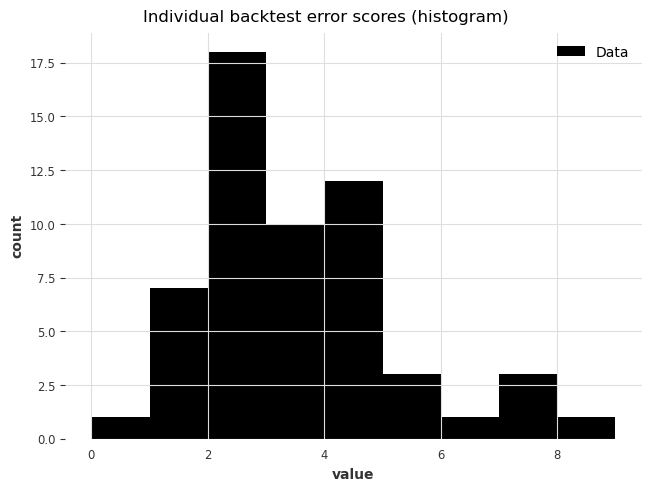

In [30]:
raw_errors = modelo_ExpSmt.backtest(
    metric=mape, reduction=None, last_points_only=False, stride=1, 
    **hfc_params
)
from darts.utils.statistics import plot_hist
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
);

In [31]:
raw_errors

array([1.76863867, 2.21659823, 5.07611964, 4.87015815, 8.19108518,
       9.86062175, 4.05701772, 2.76269298, 2.64941573, 4.47874587,
       3.09165091, 3.2276325 , 2.14981157, 1.89098603, 1.97019969,
       2.14650938, 3.62621159, 5.92339906, 5.6937021 , 3.65818476,
       2.45557393, 4.63750509, 6.51377367, 7.87590818, 7.98867397,
       9.00273818, 7.49157366, 4.16256375, 2.2530832 , 4.7386312 ,
       4.74833361, 3.35185977, 1.83699702, 2.25279537, 2.18232161,
       1.58155492, 2.46758456, 2.88638256, 4.08268054, 2.29372444,
       2.62373347, 2.89542913, 4.38378811, 3.56841019, 2.4379789 ,
       1.93671216, 2.21763245, 1.88850543, 3.70320539, 4.74816701,
       4.68851094, 4.6778566 , 3.70446406, 3.16961329, 2.14048508,
       0.80635583, 2.04061953, 3.02332721])

In [32]:
raw_errors.mean()

3.7718695788850605

historical forecasts:   0%|          | 0/20 [00:00<?, ?it/s]

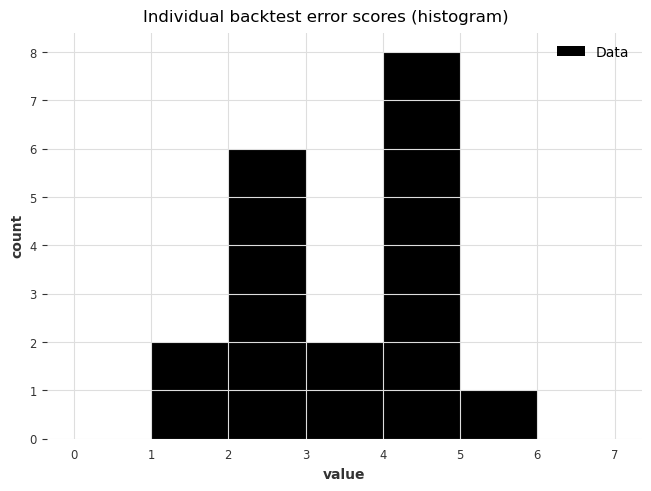

In [33]:
raw_errors = modelo_ExpSmt.backtest(
    metric=mape, reduction=None, last_points_only=False, stride=3, **hfc_params
)
from darts.utils.statistics import plot_hist
plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
);

In [34]:
raw_errors

array([1.76863867, 4.87015815, 4.05701772, 4.47874587, 2.14981157,
       2.14650938, 5.6937021 , 4.63750509, 7.98867397, 4.16256375,
       4.74833361, 2.25279537, 2.46758456, 2.29372444, 4.38378811,
       1.93671216, 3.70320539, 4.6778566 , 2.14048508, 3.02332721])

In [35]:
raw_errors.mean()

3.6790569416026324

## Modelos de pronóstico por regresión

La librería **Darts** permite utilizar modelos supervisados de corte transversal para realizar "pronósticos".
Internamente, las series temporales se transforman en formato tabular para construir un conjunto de datos de entrenamiento adecuado, que incluyen valores pasados rezagados de la serie objetivo, así como covariables. Estos modelos permiten definir covariables estáticas (País, Región, Nivel de ingresos, tamaño, ...) , aprovechar conocimiento de covariables futuras (por ejemplo días festivos o fines de semana futuros, predicciones meteorológicas, programación de campañas de marketing futuras, ...), utilizar embeddings, entre otras funcionalidades.

La clase `RegressionModel` empaqueta cualquier modelo de regresión compatible con **sklearn**. Sus principales argumentos que recibe esta clase son:
- `model`: una instancia de un modelo compatible con **scikit-learn**, que tenga los métodos `fit()` y `predict()`. Si no se especifica, se utiliza por defecto `sklearn.linear_model.LinearRegression(n_jobs=-1)`.
- `lags` (`Union[int, list[int], dict[str, Union[int, list[int]]], None]`): Valores rezagados de la serie objetivo utilizados para predecir los próximos pasos.
  - Si es un entero > 0: Usa los últimos n=lags rezagos pasados (e.g., -1, -2, ..., `-lags`) como variables predictivas. Si `output_chunk_shift` > 0, entonces el rezago `(-1)` se traduce a `(-1 - output_chunk_shift)` pasos antes del primer paso de predicción.
  - Si es una lista de enteros negativos: Usa solo los rezagos específicos indicados. Deben ser todos enteros negativos ya que son valores pasados.
  - Si es un diccionario: Permite definir rezagos específicos para componentes de series multivariadas, con la clave 'default_lags' como predeterminada para los componentes no especificados.
- `lags_past_covariates` (`Union[int, list[int], dict[str, Union[int, list[int]]], None]`): Valores rezagados de las covariables pasadas utilizados para predecir los próximos pasos. La lógica es similar al parámetro lags.
- `lags_past_covariates` (`Union[tuple[int, int], list[int], dict[str, Union[tuple[int, int], list[int]]], None]`): Valores rezagados de las covariables futuras utilizados para predecir los próximos pasos.
  - Si es una tupla (pasado, futuro), ambos valores deben ser > 0: Considera n=pasado rezagos pasados y n=futuro rezagos futuros.
  - Si es una lista de enteros: Usa solo los rezagos especificados.
  - Si es un diccionario: Define rezagos específicos para componentes multivariados, con la clave 'default_lags' como predeterminada.
- `output_chunk_length` (`int`): Número de pasos temporales que predice el modelo a la vez. Si el horizonte de predicción (n) es menor o igual a este valor, evita la autorregresión.
- `output_chunk_shift` (`int`): Opcionalmente, define un número de pasos de desplazamiento entre el final del segmento de entrada y el comienzo del segmento de salida. Esto crea un espacio entre el historial y las predicciones. Tiene un efecto importante a tener en cuenta en la definición de los diferentes `lags`.

Para mayor conveniencia, **Darts** también ofrece algunos modelos predefinidos listos para usar:
- `LinearRegressionModel`: Envuelve `sklearn.linear_model.LinearRegression` (acepta los mismos argumentos kwargs).
- `RandomForest`: Envuelve `sklearn.ensemble.RandomForestRegressor`.
- `LightGBMModel`: Envuelve `lightgbm`.
- `XGBModel`: Envuelve `xgboost`.
- `CatBoostModel`: Envuelve `catboost`.

A continuación vamos a ilustrar cómo se utiliza un modelo `RegressionModel` de **Darts** con el siguiente ejemplo. Utilizaremos:
- la serie de tiempo de pasajeros aereos como serie objetivo.
- una covariable pasada que simule una tendencia simulada
- una covariable futura que indique el periodo del mes final del año.
- un scaler para normalizar los datos y eventualmente ayudar en el rendimiento de los modelos que los necesiten
- el 80% de las series como dataset de entrenamiento.
- un modelo `sklearn.ensemble.RandomForestRegressor` como base.
 


### Inclusión de covariables pasadas

In [55]:
# Crear una covariable pasada que simule una tendencia
time_index = series.time_index
past_covariates = TimeSeries.from_times_and_values(
    time_index, np.linspace(0, 1, len(series))
)
past_covariates.values()[:5]

array([[0.        ],
       [0.00699301],
       [0.01398601],
       [0.02097902],
       [0.02797203]])

In [56]:
past_covariates.values()[-5:]

array([[0.97202797],
       [0.97902098],
       [0.98601399],
       [0.99300699],
       [1.        ]])

In [57]:
# Normalizamos los datos
from darts.dataprocessing.transformers import Scaler

scaler_target = Scaler()
scaler_past_covariates = Scaler()
target_series = scaler_target.fit_transform(series)
past_covariates = scaler_past_covariates.fit_transform(past_covariates)


In [91]:
# Configuramos el modelo RegressionModel con RandomForest como modelo subyacente
from darts.models import RegressionModel
from sklearn.ensemble import RandomForestRegressor

num_lags_current_series=12 # Los últimos 12 pasos de la serie objetivo a usar como 12 variables de entrada
num_lags_past_covariates=5 # Los últimos 5 pasos de la serie de covariables pasadas a usar como 5 variables de entrada
ventana_prediccion=3 # Número de pasos en el futuro a pronosticar. El modelo para cada predicción pronostica 3 valores de pasos futuros

model = RegressionModel(
    lags=num_lags_current_series,  
    lags_past_covariates=num_lags_past_covariates,  
    model=RandomForestRegressor(n_estimators=100, random_state=42),
    output_chunk_length=ventana_prediccion
)

In [92]:
model

RegressionModel(lags=12, lags_past_covariates=5, lags_future_covariates=None, output_chunk_length=3, output_chunk_shift=0, add_encoders=None, model=RandomForestRegressor(random_state=42), multi_models=True, use_static_covariates=True)

In [93]:
model.model

RandomForestRegressor(random_state=42)

In [94]:
# Particionamos las series de tiempo de entrenamiento
train_target, val_target = target_series.split_after(0.8)
train_past_cov, _ = past_covariates.split_after(0.8)

Al entrenar el modelo definimos la serie objetivo y la covariable pasada.

In [95]:
# Entrenamos el modelo
model.fit(
    series=train_target[:],
    past_covariates=train_past_cov[:],
)

RegressionModel(lags=12, lags_past_covariates=5, lags_future_covariates=None, output_chunk_length=3, output_chunk_shift=0, add_encoders=None, model=RandomForestRegressor(random_state=42), multi_models=True, use_static_covariates=True)

Analicemos la correspondencia de las fechas de inicio y fin de las series para poder configurar el cubrimiento necesario de la covariable en términos de lags necesarios.

In [96]:
train_target.time_index[-1]

Timestamp('1958-07-01 00:00:00')

In [97]:
print(f"desde: {val_target.time_index[0]}")
print(f"hasta: {val_target.time_index[-1]}")

desde: 1958-08-01 00:00:00
hasta: 1960-12-01 00:00:00


Vemos que el primer paso de tiempo para el pronóstico en la serie objetivo es el mes de Agosto de 1958, y el último valor va hasta Diciembre de 1960.
Es importante entender que las series de covariables pasadas deben contar con datos anteriores y posteriores a los datos de la serie de tiempo objetivo que se enviará como argumento al método `predict()`.
Tenemos que tener en cuenta el hiperparámetro `lags_past_covariates` pues su valor tendrá como efecto la necesidad de más o menos pasos de tiempo en las series de covariables pasadas.
La serie `past_covariates` que se envía a `predict()` debe tener tantos datos previos al comienzo de la series objetivo como lo indica `lags_past_covariates`. En este caso, como se quieren usar los 5 valores anteriores, necesitamos que la serie `past_covariates` comience en Marzo de 1958.

In [98]:
past_covariates_index_start = int(len(past_covariates)*0.8) - 5
past_covariates.time_index[past_covariates_index_start]

Timestamp('1958-03-01 00:00:00')

In [99]:
# Preparación de covariables para la inferencia.
_, val_past_cov = past_covariates.split_before(past_covariates.time_index[past_covariates_index_start])
val_past_cov.time_index[0]

Timestamp('1958-03-01 00:00:00')

Al llamar al método `predict()`.
Para tener en cuenta, no vamos a enviar nuevos valores de la serie objetivo, por lo que por defecto toma como punto de partida temporal el último paso de tiempo de esta serie durante el entrenamiento. También se podría pasar otra serie objetivo con diferente punto de finalización temporal, si se requiere referirse a otro momento para el forecasting.
Se debe establecer explícitamente cuántos valores futuros a pronósticar queremos; con `n=3` estamos diciendo que queremos 3 valores futuros. 

Es importante tener en cuenta que si `n <= output_chunk_length`, el modelo puede llegar a pronósticar todos sus valores en un solo paso predictivo, pero en el caso contrario, el modelo utilizará los valores previamente predichos auto-regresivamente.

Veamos cómo sería con `n>3`:

In [100]:
# Generar predicciones
forecast = model.predict(
    n=4,
    past_covariates=val_past_cov,
)
[(t, v) for (t, v) in zip(forecast.time_index, forecast.values())]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[(Timestamp('1958-08-01 00:00:00'), array([0.63293436])),
 (Timestamp('1958-09-01 00:00:00'), array([0.64214286])),
 (Timestamp('1958-10-01 00:00:00'), array([0.59030888])),
 (Timestamp('1958-11-01 00:00:00'), array([0.50611969]))]

Recordemos que al crear el modelo, definimos `output_chunk_length=3`, por lo que en este caso (`n=3`), no se hará uso del modelo auto regresivamente.

In [103]:
# Generar predicciones
forecast = model.predict(
    n=3, 
    past_covariates=val_past_cov,
)
[(t, v) for (t, v) in zip(forecast.time_index, forecast.values())]

[(Timestamp('1958-08-01 00:00:00'), array([0.63293436])),
 (Timestamp('1958-09-01 00:00:00'), array([0.64214286])),
 (Timestamp('1958-10-01 00:00:00'), array([0.59030888]))]

El valor de `n` está acotado hacia arriba al alcance temporal de la serie de covariables pasadas disponibles.
por ejemplo, consideremos solo los primeros 10 valores de la serie de tiempo de la covariable pasada:

In [104]:
val_past_cov[:10].time_index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')

In [105]:
train_target.time_index[-1]

Timestamp('1958-07-01 00:00:00')

Como tenemos un valor de `output_chunk_length=3`, la primera predicción del modelo tendrá en cuenta la última ventana de datos de entrenamiento de la variable objetivo de y de la covariable (meses de Marzo a Julio de 1958), y nos producira predicciones para los meses de Agosto, Septiembre y Octubre de 1958. De la misma manera la última ventana de 5 los últimos datos de la covariable (correspondientes a los meses de Agosto a Diciembre de 1958) permitirán predecir los siguientes 3 pasos de tiempo (Enero a Marzo 1959). 
Es decir que con una ventana de información de 10 datos, podremos llegar a predecir 8 valores futuros.

La relación es la siguiente:
$$n_{max} = len(val past cov) - output chunk length + 1$$

In [106]:
# Generar predicciones
forecast = model.predict(
    n=8,
    past_covariates=val_past_cov[:10],
)

[(t, v) for (t, v) in zip(forecast.time_index, forecast.values())]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[(Timestamp('1958-08-01 00:00:00'), array([0.63293436])),
 (Timestamp('1958-09-01 00:00:00'), array([0.64214286])),
 (Timestamp('1958-10-01 00:00:00'), array([0.59030888])),
 (Timestamp('1958-11-01 00:00:00'), array([0.52276062])),
 (Timestamp('1958-12-01 00:00:00'), array([0.51998069])),
 (Timestamp('1959-01-01 00:00:00'), array([0.50399614])),
 (Timestamp('1959-02-01 00:00:00'), array([0.5215251])),
 (Timestamp('1959-03-01 00:00:00'), array([0.53449807]))]

### Inclusión de covariables futuras

In [107]:
# Crear la covariable futura: 1 si es diciembre, 0 en caso contrario
future_values = np.where(time_index.month == 12, 1, 0)

# Crear un TimeSeries con esta covariable
future_covariates = TimeSeries.from_times_and_values(time_index, future_values)
future_covariates.values()[0:13]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [108]:
future_covariates.values()[-13:]

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [109]:
# Normalizamos los datos
scaler_future_covariates = Scaler()
future_covariates = scaler_future_covariates.fit_transform(future_covariates) # realmente no se necesita pues está entre 0 y 1

In [110]:
future_covariates.values()[0:13]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]])

Para el argumento `lags_future_covariates`, se puede tomar una covariable que combine tanto valores pasados como futuros de la misma, utilizando una tupla. En nuestro caso vamos a considerar los 4 siguientes valores de los siguientes 4 pasos de tiempo como variables predictivas.
Otro tipo de configuración posible es el de utilizar una lista, con los índices de los lags pasados y futuros que se desea considerar como variables.

In [111]:
# Configuramos el modelo RegressionModel con RandomForest como modelo subyacente con future covariates
num_lags_current_series=12 # Los últimos 12 pasos de la serie objetivo a usar como 12 variables de entrada
num_lags_past_covariates=5 # Los últimos 5 pasos de la serie de covariables pasadas a usar como 5 variables de entrada
num_lags_future_covariates=(0, 4) # Utilizar los siguientes 4 pasos futuros de la serie de covariables futuras como 4 variables de entrada
ventana_prediccion=3 # Número de pasos en el futuro a pronosticar. El modelo para cada predicción pronostica 3 valores de pasos futuros

model = RegressionModel(
    lags=num_lags_current_series,  
    lags_past_covariates=num_lags_past_covariates,  
    lags_future_covariates=num_lags_future_covariates,
    model=RandomForestRegressor(n_estimators=100, random_state=42),
    output_chunk_length=ventana_prediccion
)

In [112]:
# Particionamos las series de tiempo de entrenamiento
train_target, val_target = target_series.split_after(0.8)
train_past_cov, _ = past_covariates.split_after(0.8)
train_future_cov, _ = future_covariates.split_after(0.8)

In [113]:
# Entrenamos el modelo
model.fit(
    series=train_target[:],
    past_covariates=train_past_cov[:],
    future_covariates=train_future_cov[:]
)

RegressionModel(lags=12, lags_past_covariates=5, lags_future_covariates=(0, 4), output_chunk_length=3, output_chunk_shift=0, add_encoders=None, model=RandomForestRegressor(random_state=42), multi_models=True, use_static_covariates=True)

Para la covariable pasada ya conocemos la configuración a realizar en términos de alcance temporal a considerar para la predicción.

In [114]:
# Preparación de la covariable pasada
past_covariates_index_start = int(len(past_covariates)*0.8) - 5
_, val_past_cov = past_covariates.split_before(past_covariates.time_index[past_covariates_index_start])

En términos de la covariable futura también es necesario considerar que el número de pasos de tiempo disponibles en la serie y la configuración del número de pasos de tiempo predichos en una sola inferencia limitan el número de valores futuros a pronosticar en la serie objetivo.
Es importante tener en cuenta que si `n <= output_chunk_length`, el modelo puede llegar a pronósticar todos sus valores en un solo paso predictivo, pero en el caso contrario, el modelo utilizará los valores previamente predichos auto-regresivamente.

In [125]:
train_future_cov, val_future_cov = future_covariates.split_after(0.8)

Vamos a considerar solo una serie futura de 10 valores.

In [131]:
train_target.time_index[-1] # Último paso de tiempo de entrenamiento, el primer valor a pronosticar será el mes siguiente

Timestamp('1958-07-01 00:00:00')

In [133]:
val_future_cov.time_index[0] # El primer valor de la covariable futura coincide con el primer paso de tiempo a pronosticar (lag 0)

Timestamp('1958-08-01 00:00:00')

In [132]:
val_future_cov.time_index[9] # Décimo valor de la serie de la covariable futura

Timestamp('1959-05-01 00:00:00')

Recordemos que el primer valor a pronosticar para la serie de tiempo objetivo será para Agosto de 1958 (el training set va hasta Julio de 1958).
Como configuramos en la creación del modelo en su argumento `lags_future_covariates=(0,4)`, solo tendremos un compomente futuro de esta covariable, que considerará los siguientes 4 pasos de tiempo.
Es decir que para predecir el valor de Agosto, Septiembre y Octubre de 1958 (recordemos que `output_chunk_length=3`) para la variable objetivo, además de los datos de la covariable pasada, se utilizarán los valores de Agosto, Septiembre, Octubre y Noviembre de 1958 para la covariable futura.

Como el 10° valor de la serie de tiempo de la covariable futura corresponde al mes de Mayo de 1959, los últimos 4 lags futuros incluye los valores de Febrero, Marzo, Abril, y Mayo de 1959. Es decir que los últimos valores que podemos predecir para la variable objetivo corresponden a Febrero, Marzo y Abril de 1959, llevando el máximo número de valores futuros a pronosticar a `n=9` (de Agosto 1958 a Abril de 1959).

In [134]:
# Generar predicciones
forecast = model.predict(
    n=9,
    past_covariates=val_past_cov,
    future_covariates=val_future_cov[:10],
)
[(t, v) for (t, v) in zip(forecast.time_index, forecast.values())]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[(Timestamp('1958-08-01 00:00:00'), array([0.63864865])),
 (Timestamp('1958-09-01 00:00:00'), array([0.63169884])),
 (Timestamp('1958-10-01 00:00:00'), array([0.56876448])),
 (Timestamp('1958-11-01 00:00:00'), array([0.51083012])),
 (Timestamp('1958-12-01 00:00:00'), array([0.50416988])),
 (Timestamp('1959-01-01 00:00:00'), array([0.49138996])),
 (Timestamp('1959-02-01 00:00:00'), array([0.52498069])),
 (Timestamp('1959-03-01 00:00:00'), array([0.54631274])),
 (Timestamp('1959-04-01 00:00:00'), array([0.55063707]))]

La relación es la siguiente con respecto a la covariable futura:
$$n_{max} = len(val\ past\ cov) - max(lags\ future\ covariates) + output\ chunk\ length$$

Al combinar lags pasados y futuros, se toma el mínimo de los dos valores de `n` máximo.

Para finaliza, los valores futuros pronosticados escalados, hay que transformarlos de vuelta a la escala original.

In [136]:
forecast = scaler_target.inverse_transform(forecast)
forecast.values()

array([[225340.76],
       [223475.96],
       [206589.16],
       [191043.98],
       [189256.88],
       [185827.72],
       [194840.92],
       [200564.82],
       [201725.14]])